## Gaussian process analysis of a well-sampled time course

Here we are going to apply Gaussian Process analysis to a fantastic data set as an example of a best case scenario.

The data is from [Owens et al 2016, _Cell Reports_](http://dx.doi.org/10.1016/j.celrep.2015.12.050): **Measuring Absolute RNA Copy Numbers at High Temporal Resolution Reveals Transcriptome Kinetics in Development**. In this study, the authors fertilise Xenopus embryos, and sample embryos at 30 to 60 minute intervals for 66 hours. RNA-sequencing was then performed on the whole sampled embryos.

![](img/timecourse.png)

While this data is not single cell, but rather single embryo, it is an extremely well performed experiment, and shows very clear dynamics over development

First we load some helper functionality

The scrnatab library is available at https://github.com/Teichlab/scrnatb

In [1]:
%pylab inline
%run ../scrnatb/scrnatb/toolbox.py

Populating the interactive namespace from numpy and matplotlib


The data is stored as a matrix of TPM values. After we load this we use the helper function `exogen_scale_tpm` to remove ERCC spike-ins and rescale the TPMs. This is because we are only interested in relative abundance within embryos, for the sake of simplicity.

In [2]:
tpm = pd.read_csv('frog-data/GSE65785_clutchApolyA_relative_TPM.csv', index_col=0)

etpm = exogen_scale_tpm(tpm, prefix='ERCC')

In [3]:
etpm.iloc[:5, :5]

,Sample_00,Sample_01,Sample_02,Sample_03,Sample_04
1012069980|,689.213661,789.644659,814.644371,777.487929,804.649415
1012070007|,1110.484407,1172.132453,1229.892101,1138.343887,967.418969
1012070179|,173.903799,156.500177,156.136904,151.726532,140.493795
1012070219|,753.346074,760.294471,726.796628,692.689176,597.897116
1012070250|,46.272623,50.592690,75.540421,99.274771,109.814672


It is normally handy to have a table with all meta-data about the samples. In this case we have a table where one column is the Hour Post Fertilisation (HPF) for each sequenced embryo

In [4]:
sample_info = pd.read_csv('frog-data/sample_info.csv', index_col=0)

In [5]:
sample_info.head(5)

,hpf,ERCC
Sample_00,0.0,77564.805061
Sample_01,0.5,82697.593311
Sample_02,1.0,71609.640447
Sample_03,1.5,69384.930470
Sample_04,2.0,71681.464047


Measured expression follows a high dynamic range, where noise at high levels would mask any variation at low levels. There is some evidence that relative abundance measures are log-normally distributed, or at least similar to this. To attempt to make the data behave slightly nicer, we usually log-transform the data, with a "pseudocount" to stabilize values close to 0.

In [6]:
logexp = np.log10(etpm + 1)

Let us first have a look at some gene as an example of what we can get from this time course. I know from other contexts that ZSCAN's are important in early development, and tend to peak at interesting times. Let us see if we have any such genes in Xenopus.

In [7]:
etpm.index[etpm.index.str.contains('zscan')]

Index(['Xetro.K00623|zscan20', 'Xetro.K02648|zscan2', 'Xetro.K05048|zscan29'], dtype='object')

In [8]:
sns.set_style('whitegrid')
sns.set_context('talk')

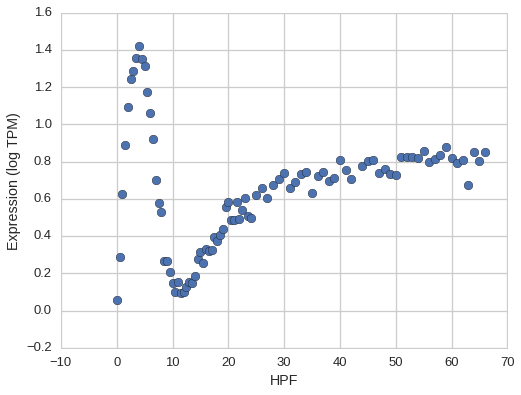

In [9]:
figsize(8, 6)
plt.scatter(sample_info['hpf'], logexp.ix['Xetro.K02648|zscan2'], s=75);
sns.axlabel('HPF', 'Expression (log TPM)')

This is definitaly an interesting pattern! And it would be hard to say anything about it with linear regression.

Can we model such a pattern? How can we find other genes with interesting expression patterns?

We use Gaussian Processes to represent the temporal expression.

In [10]:
import GPy

In [11]:
# Make the data the correct format
X = sample_info['hpf'][:, None]
Y = logexp.ix['Xetro.K02648|zscan2'][:, None]

# Choose a covariance function, RBF kernels are a good default
kernel = GPy.kern.RBF(input_dim=1)

# Make the regression model
model = GPy.models.GPRegression(X, Y, kernel=kernel)

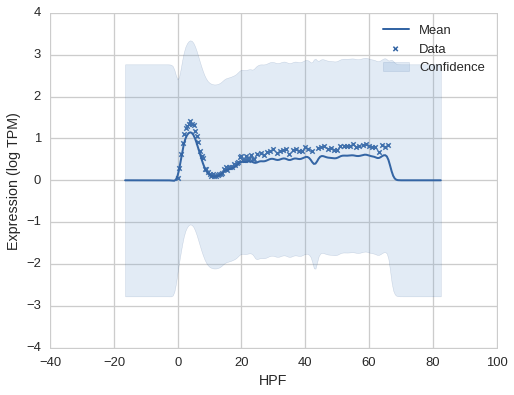

In [12]:
model.plot();
sns.axlabel('HPF', 'Expression (log TPM)')

In [13]:
model

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


This model roughly represents the pattern, but is very noisy. We `optimize` the model to find the hyper-parameters which maximizes the marginal log-likelihood of the model. (Also known as the _evidence_ of the model, given the data).

In [14]:
model.optimize()

In [15]:
model

GP_regression.,value,constraints,priors
rbf.variance,0.761821338729,+ve,
rbf.lengthscale,4.99857875574,+ve,
Gaussian_noise.variance,0.00173930248947,+ve,


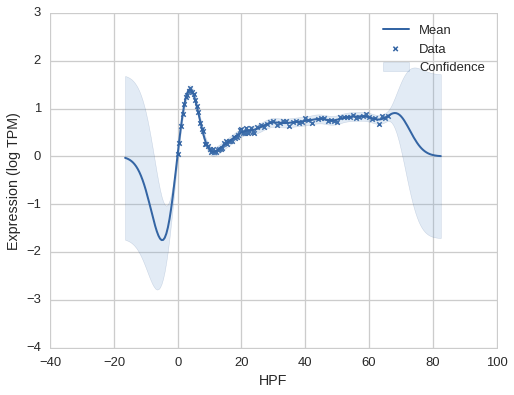

In [16]:
model.plot()
sns.axlabel('HPF', 'Expression (log TPM)')

Now the model looks much better. The low variance in the `rbf` kernel tells us the data is not noisy. And the lengthscale tells us that for this gene, "interesting" things happen in 5-hour intervals. Note how the model confidence intervals gets wider outside of the interval of obsrved data (0 to 66 HPF).

### Ranking genes by dynamic behavior

If we wanted to find genes which simply increased with the HPF, we could make a linear model for each gene using the HPF as a predictor, then compare that model to a model which only allowed noise. (This would be equivalent to looking at correlation with HPF).

Here, we use a similar strategy. When we construct the model, we can choose a covariance function which assumes the data is constant, and all variability is due to noise. This is called a _Bias kernel_.

In [17]:
# Choose a covariance function
kernel = GPy.kern.Bias(input_dim=1)

# Make the model
simple_model = GPy.models.GPRegression(X, Y, kernel=kernel)

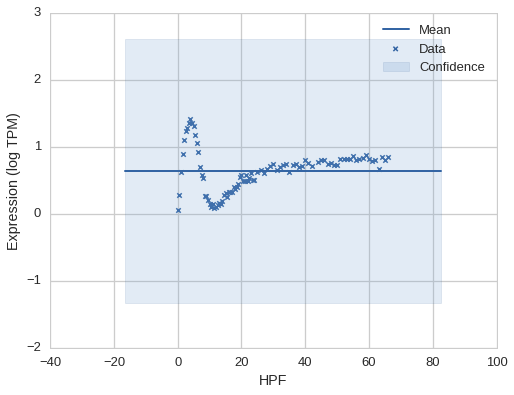

In [18]:
simple_model.plot();
sns.axlabel('HPF', 'Expression (log TPM)')

In [19]:
simple_model.optimize()

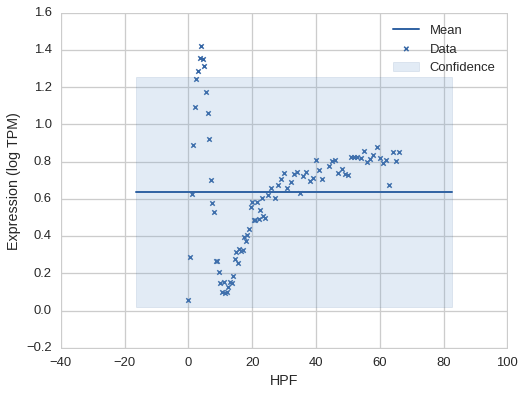

In [20]:
simple_model.plot();
sns.axlabel('HPF', 'Expression (log TPM)')

In [21]:
simple_model

GP_regression.,value,constraints,priors
bias.variance,0.409119263176,+ve,
Gaussian_noise.variance,0.0982723774441,+ve,


Note how wide the confidence interval is for this simpler model! This is an indication of the log-likelihood.

In [22]:
model.log_likelihood()

100.7744880372438

In [23]:
simple_model.log_likelihood()

-26.268288336915418

The model which allows dynamic changes over time has much higher likelihood (or evidence) than the simpler model. We express this difference as a _D statistic_, similar to a Likelihood Ratio test.

In [24]:
D_statistic = -2 * simple_model.log_likelihood() + 2 * model.log_likelihood()
D_statistic

254.08555274831843

Now we perform this for every gene, saving the optimal likelihoods for the dynamic (RBF) and static (Bias) models. For the dynamic models, we also save the covariance function hyper parameters, and perform prediction at some predefined points. This is also saved in the output tables.

This takes a while (though it parallelizes trivially), and in the interest of time it as has been performed and saved in the frog-data directory.

In [25]:
gps_rbf  = pd.read_csv('frog-data/gp_rbf.csv',  index_col=0)
gps_bias = pd.read_csv('frog-data/gp_bias.csv', index_col=0)

In [26]:
gps_rbf.head()

,log_likelihood,rbf.variance,rbf.lengthscale,Gaussian_noise.variance,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
1012069980|,129.916079,5.033686,34.205827,0.002057,2.844163,2.849075,2.854102,2.859240,2.864488,2.869840,...,0.002296,0.002319,0.002345,0.002377,0.002415,0.002459,0.002510,0.002570,0.002639,0.002718
1012070007|,110.628786,6.915259,10.731509,0.001846,3.130886,3.087276,3.048895,3.015812,2.988045,2.965565,...,0.002251,0.002251,0.002250,0.002251,0.002263,0.002296,0.002366,0.002498,0.002722,0.003080
1012070179|,63.000881,2.124302,20.252544,0.009360,2.076010,2.090993,2.105669,2.120021,2.134030,2.147678,...,0.010494,0.010590,0.010709,0.010857,0.011039,0.011258,0.011521,0.011834,0.012203,0.012635
1012070219|,118.246918,3.141406,5.932136,0.000912,2.885857,2.885839,2.877068,2.861110,2.839659,2.814481,...,0.001197,0.001214,0.001233,0.001247,0.001253,0.001250,0.001247,0.001273,0.001383,0.001678
1012070250|,131.612056,2.523964,14.505896,0.001521,1.739933,1.777015,1.813590,1.849600,1.884985,1.919687,...,0.001757,0.001761,0.001771,0.001789,0.001818,0.001863,0.001930,0.002025,0.002156,0.002333


In [27]:
# We predicted at these points for each gene
xx = np.linspace(0., 66., 200)[:,None]

Calculate the D-statistic for every gene

In [28]:
D = -2 * gps_bias['log_likelihood'] + 2 * gps_rbf['log_likelihood']

We now visualize this. Generally, we are interested in cases where the RBF model is much better than the Bias model. We compare the D-statistic with the likelihood of the Bias model so we are sure that the Bias model fits poorly.

In this case we also color the genes by the lengthscale parameter of the RBF kernel. This is an additional check that the D-statistic works. If the lengthscale is longer than the sampled interval (0 to 66 HPF), there is nothing interesting happening inside the interval. And if it would be extremely short (close to 0), it probably overfit.

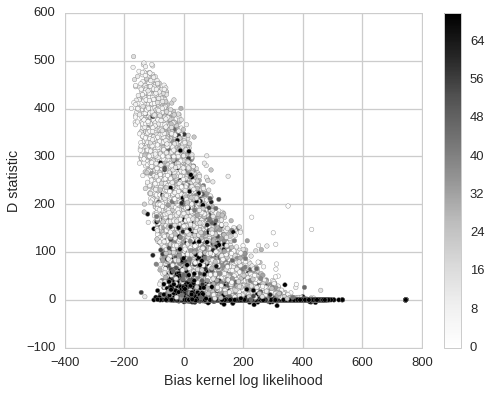

In [29]:
plt.scatter(gps_bias['log_likelihood'], D,
            edgecolor='grey',
            c=gps_rbf['rbf.lengthscale'], vmin=0, vmax=70)
plt.colorbar()

sns.axlabel('Bias kernel log likelihood', 'D statistic')

This looks great! It seems a lower threshold of 300-400 will catch a lot interesting dynamics.

_(If we want to be more quantitative about this, we can rerun the same analysis with permuted X-values. This would allow us to estimate a null-distribution of D-statistics, and control false discovery rate. This has been left out in the interest of simplicity)_

In [30]:
varying = D[(D > 300)].index
varying.shape

(2437,)

In [31]:
gp_features = pd.DataFrame({'D': D})

In [32]:
# Predicted means for each GP are stored in columns 4 to 204
gps_rbf.ix[:, 4:204].iloc[:5, :5]

,mu_0,mu_1,mu_2,mu_3,mu_4
1012069980|,2.844163,2.849075,2.854102,2.859240,2.864488
1012070007|,3.130886,3.087276,3.048895,3.015812,2.988045
1012070179|,2.076010,2.090993,2.105669,2.120021,2.134030
1012070219|,2.885857,2.885839,2.877068,2.861110,2.839659
1012070250|,1.739933,1.777015,1.813590,1.849600,1.884985


An example downstream analysis one could do from here would be to look at functional enrichment analysis of the dynamic genes.

Here, let us skip that and move towards something more interesting.

The command below might be a bit difficult to interpret. What it does, is that it finds the time point where the Gaussian Process' posterior mean takes its largest value. We refer to this as the "peak time" of the Gaussian Process.

In [33]:
gp_features['peak_time'] = xx[gps_rbf.ix[:, 4:204].as_matrix().argmax(1)]

We then sort the varying/dynamic genes based on this peak time, earliest first.

In [34]:
varying = \
gp_features \
.ix[varying] \
.sort_values('peak_time', ascending=True).index

To highlight the temporal expression pattern of each gene, we Z-score scale the Gaussian Process means

In [35]:
from sklearn import preprocessing
scaled_gp_means = preprocessing.scale(gps_rbf.ix[varying, 4:204], 1)

And then we plot this as a heatmap. Here every row is a dynamic gene, and the X-axis is the Hour Post Fertilization, ranging from 0 to 66 hours.

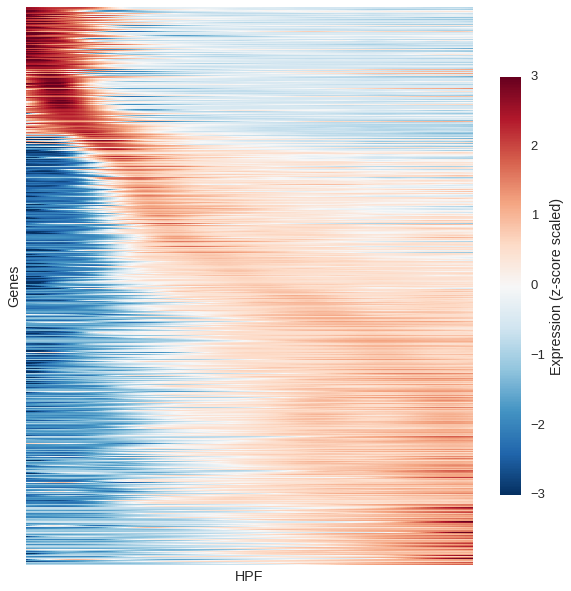

In [36]:
figsize(10, 10)
sns.heatmap(scaled_gp_means, lw=0,
            yticklabels=False,
            xticklabels=False,
            cbar_kws={'label': 'Expression (z-score scaled)', 'shrink':.75},
            cmap=cm.RdBu_r, vmin=-3, vmax=2.5);

sns.axlabel('HPF', 'Genes')

We can immidiately see interesting expression dynamics! We see early genes depleting, most likely maternally deposited. We see some wave of activation, and we see what looks like a smaller wave. We have an ordering of which genes peaks first.

There are other ways of sorting the genes, e.g. when is the initial expression? But for now this satisfies us.

To finish off, let us look at some examples of dynamic genes' Gaussian Processes.

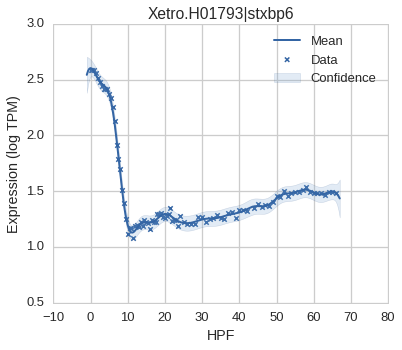

In [37]:
figsize(6, 5)
sub_index = 50

X = sample_info.hpf[:, None]
Y = logexp.ix[varying[sub_index]][:, None]
m = GPy.models.GPRegression(X, Y)
m.optimize()
m.plot(plot_limits=[-1, 67]);
plt.title(varying[sub_index]);
sns.axlabel('HPF', 'Expression (log TPM)')

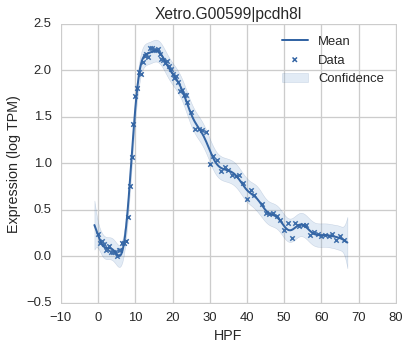

In [38]:
figsize(6, 5)
sub_index = 700

X = sample_info.hpf[:, None]
Y = logexp.ix[varying[sub_index]][:, None]
m = GPy.models.GPRegression(X, Y)
m.optimize()
m.plot(plot_limits=[-1, 67]);
plt.title(varying[sub_index]);
sns.axlabel('HPF', 'Expression (log TPM)')

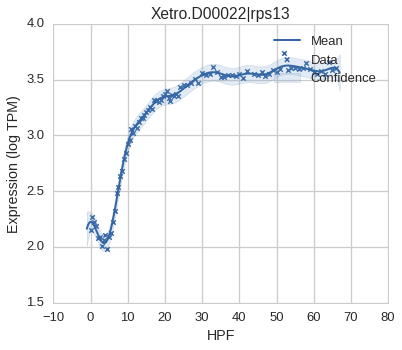

In [39]:
figsize(6, 5)
sub_index = 1500

X = sample_info.hpf[:, None]
Y = logexp.ix[varying[sub_index]][:, None]
m = GPy.models.GPRegression(X, Y)
m.optimize()
m.plot(plot_limits=[-1, 67]);
plt.title(varying[sub_index]);
sns.axlabel('HPF', 'Expression (log TPM)')